In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import plotly.express as px
import json, csv
from shapely.geometry import Point
from shapely import Polygon

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
#import os

# os.chdir allows you to change directories, like cd in the Terminal
# os.chdir('./drive/MyDrive/Colab Notebooks/project')

# Predicting Bike-Sharing Demand in Munich

## Data Selection & Preprocessing

In [12]:
dfs = []
meta = {'years':[], 'n_columns':[], 'n_rows':[]}
for year in range(2019,2023,1):
    df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
    cols = [col.strip() for col in df.columns]
    df.columns = cols
    dfs.append(df)
    meta['years'].append(year)
    meta['n_columns'].append(df.shape[1])
    meta['n_rows'].append(df.shape[0])
    
meta_df = pd.DataFrame(meta).set_index('years')
meta_df

/tmp/ipykernel_20256/444130960.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_20256/444130960.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')
/tmp/ipykernel_20256/444130960.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../raw_data/MVG_Rad_Fahrten_{year}.csv', sep=';')


,n_columns,n_rows
years,,
2019,11,753678
2020,11,721752
2021,11,619573
2022,11,709144


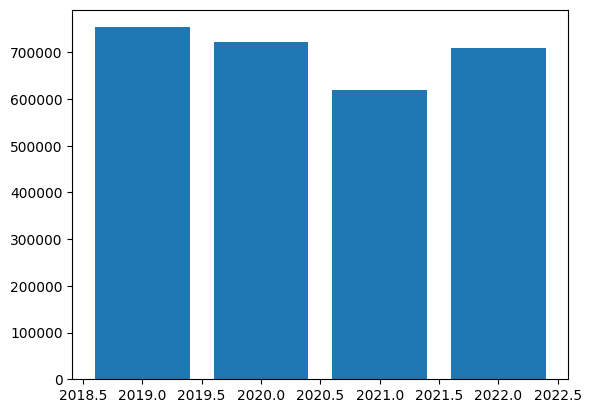

In [13]:
plt.bar(meta_df.index, meta_df['n_rows']);

In [14]:
def pre_process_df(df):
  #vstrip column names
  cols = [col.strip() for col in df.columns]
  df.columns = cols

  # remove column 'Row'
  if 'Row' in df.columns:
    df.drop(columns='Row', inplace=True)

  # select relevant columns only
  df = df[['STARTTIME', 'STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']].copy()
  
  # make string replacements values
  df_obj = df.select_dtypes(include='object')
  df[df_obj.columns] = df_obj.applymap(lambda x: x.strip().replace(',', '.') if isinstance(x, str) else x)

  # handle datetime
  df.STARTTIME = pd.to_datetime(df.STARTTIME)

  # handle numeric columns
  df.replace('NULL', np.NAN, inplace=True)
  df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']] = df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']].astype(np.float32)
  
  return df

In [17]:
dfs_preproc = []
for df in dfs:
  dfs_preproc.append(pre_process_df(df))

In [18]:
df_all = pd.concat(dfs_preproc, axis=0).reset_index().drop(columns='index')
df_all.shape

(2804147, 4)

In [19]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2804147 entries, 0 to 2804146
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   STARTTIME          datetime64[ns]
 1   STARTLAT           float32       
 2   STARTLON           float32       
 3   RENTAL_IS_STATION  float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 53.5 MB


In [20]:
df_all['year'] = df_all['STARTTIME'].map(lambda x : x.year)
df_all['month'] = df_all['STARTTIME'].map(lambda x : x.month)
df_all['hour'] = df_all['STARTTIME'].map(lambda x : x.hour)
df_all['date_hour'] = df_all['STARTTIME'].dt.floor('H')

In [21]:
df_all.head()

,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION,year,month,hour,date_hour
0,2019-01-01 00:26:00,48.118450,11.51556,1.0,2019,1,0,2019-01-01
1,2019-01-01 00:32:00,48.138290,11.56943,0.0,2019,1,0,2019-01-01
2,2019-01-01 00:49:00,48.170971,11.57294,1.0,2019,1,0,2019-01-01
3,2019-01-01 00:50:00,48.170971,11.57294,1.0,2019,1,0,2019-01-01
4,2019-01-01 00:58:00,48.117119,11.52634,1.0,2019,1,0,2019-01-01


## Adding Districts and Grouping by Hour

In [24]:
polygons = {}
# load coordinates for districts from csv and sava them in a dict of Polygons
with open('../raw_data/polygons.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        polygons[row['district']] = Polygon(json.loads(row['coordinates']))

In [25]:
df_all['geo_points'] = df_all[['STARTLON', 'STARTLAT']].apply(lambda x: Point(x.STARTLON, x.STARTLAT), axis=1)

In [26]:
for district, poly in polygons.items():
    df_all[district] = df_all.apply(lambda x: poly.contains(x.geo_points), axis=1)
    
df_all.head(3)


,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION,year,month,hour,date_hour,geo_points,Maxvorstadt,...,Altstadt-Lehel,Sendling-Westpark,Neuhausen-Nymphenburg,Schwabing-Freimann,Pasing-Obermenzing,Aubing-Lochhausen-Langwied,Milbertshofen-Am Hart,Bogenhausen,Trudering-Riem,Untergiesing-Harlaching
0,2019-01-01 00:26:00,48.118450,11.51556,1.0,2019,1,0,2019-01-01,POINT (11.515560150146484 48.11845016479492),False,...,False,True,False,False,False,False,False,False,False,False
1,2019-01-01 00:32:00,48.138290,11.56943,0.0,2019,1,0,2019-01-01,POINT (11.569430351257324 48.13829040527344),False,...,True,False,False,False,False,False,False,False,False,False
2,2019-01-01 00:49:00,48.170971,11.57294,1.0,2019,1,0,2019-01-01,POINT (11.5729398727417 48.17097091674805),False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
df_all.to_csv('../raw_data/2023-05-25_all_data.csv', index=False)

In [ ]:
df_all = pd.read_csv('data/2023-05-25_all_data.csv', parse_dates=True, date_parser={'STARTTIME':'%Y-%M-%d %H:%m:%s'})
df_all.head()

,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION,year,month,hour,date_hour,geo_points,Maxvorstadt,...,Altstadt-Lehel,Sendling-Westpark,Neuhausen-Nymphenburg,Schwabing-Freimann,Pasing-Obermenzing,Aubing-Lochhausen-Langwied,Milbertshofen-Am Hart,Bogenhausen,Trudering-Riem,Untergiesing-Harlaching
0,2019-01-01 00:26:00,48.11845,11.51556,1.0,2019,1,0,2019-01-01 00:00:00,POINT (11.515560150146484 48.11845016479492),False,...,False,True,False,False,False,False,False,False,False,False
1,2019-01-01 00:32:00,48.13829,11.56943,0.0,2019,1,0,2019-01-01 00:00:00,POINT (11.569430351257324 48.13829040527344),False,...,True,False,False,False,False,False,False,False,False,False
2,2019-01-01 00:49:00,48.17097,11.57294,1.0,2019,1,0,2019-01-01 00:00:00,POINT (11.5729398727417 48.17097091674805),False,...,False,False,False,False,False,False,False,False,False,False
3,2019-01-01 00:50:00,48.17097,11.57294,1.0,2019,1,0,2019-01-01 00:00:00,POINT (11.5729398727417 48.17097091674805),False,...,False,False,False,False,False,False,False,False,False,False
4,2019-01-01 00:58:00,48.11712,11.52634,1.0,2019,1,0,2019-01-01 00:00:00,POINT (11.526339530944824 48.11711883544922),False,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
df_all[['STARTTIME', 'date_hour']] = df_all[['STARTTIME', 'date_hour']].apply(pd.to_datetime)

KeyError: "['STARTTIME'] not in index"

In [ ]:
relevant_cols = list(set(df_all.columns) - set(['STARTTIME', 'STARTLAT', 'STARTLON', 'geo_points']))

In [ ]:
agg_dict = {col: np.mean 
            if col in ['RENTAL_IS_STATION', 'year', 'month', 'hour', 'date_hour'] 
            else np.sum 
            for col in relevant_cols}

In [ ]:
df_by_hour = df_all[relevant_cols].groupby('date_hour').agg(agg_dict)
df_by_hour.reset_index(drop=True, inplace=True)
df_by_hour.head()

,Harlaching,Südgiesing,Hasenbergl-Lerchenau Ost,Obergiesing,Pasing,Sendling,Moosach,Feldmoching,Pasing-Obermenzing,Ludwigsvorstadt-Isarvorstadt,...,date_hour,Berg am Laim,Trudering,Schwabing-West,Obersendling,Hadern,Bogenhausen,year,Untergiesing,Ramersdorf-Perlach
0,0,0,0,0,0,0,0,0,0,0,...,2019-01-01 00:00:00,0,0,3,0,0,0,2019.0,0,0
1,0,0,0,0,0,2,1,0,0,0,...,2019-01-01 01:00:00,0,0,3,0,0,2,2019.0,1,0
2,0,0,0,2,0,5,0,0,0,3,...,2019-01-01 02:00:00,0,0,2,0,0,2,2019.0,1,0
3,0,0,0,0,0,0,1,0,0,1,...,2019-01-01 03:00:00,0,0,5,0,0,0,2019.0,1,0
4,0,0,0,3,0,0,2,0,0,3,...,2019-01-01 04:00:00,0,0,4,0,0,0,2019.0,0,0


In [ ]:
df_by_hour.shape

(34718, 41)

## Aggregating with Weather Data

In [ ]:
url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    'latitude': 48.14,
    'longitude': 11.58, 
    'start_date': '2019-01-01',
    'end_date': '2022-12-31',
    'hourly': ['temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'windspeed_10m', 'precipitation']
}

weather_data = requests.get(url, params=params).json()

In [ ]:
weather_data_hourly = weather_data['hourly']
df_weather = pd.DataFrame(weather_data_hourly)
df_weather.head()

,time,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
0,2019-01-01T00:00,3.3,97,0.2,9.8,0.0
1,2019-01-01T01:00,3.0,97,-0.1,9.9,0.0
2,2019-01-01T02:00,3.0,96,-0.2,10.4,0.0
3,2019-01-01T03:00,3.0,96,-0.3,10.5,0.0
4,2019-01-01T04:00,2.9,96,-0.4,11.2,0.0


In [ ]:
df_weather.shape

(35064, 6)

In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['time'])


In [ ]:
data = df_by_hour.merge(df_weather, left_on='date_hour', right_on='time', how='left').drop(columns='time')


In [ ]:
data.describe()

,Harlaching,Südgiesing,Hasenbergl-Lerchenau Ost,Obergiesing,Pasing,Sendling,Moosach,Feldmoching,Pasing-Obermenzing,Ludwigsvorstadt-Isarvorstadt,...,Hadern,Bogenhausen,year,Untergiesing,Ramersdorf-Perlach,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
count,34718.000000,34718.000000,34718.000000,34718.000000,34718.000000,34718.000000,34718.00000,34718.000000,34718.000000,34718.000000,...,34718.000000,34718.000000,34718.000000,34718.000000,34718.000000,32312.000000,32312.000000,32312.000000,32312.000000,32312.000000
mean,0.218820,0.124633,0.111642,1.545740,0.361311,3.173685,2.04237,0.056282,0.527162,7.610231,...,0.596837,2.377182,2020.498877,1.838240,1.197448,9.465103,77.458498,7.294692,9.782304,0.114484
std,0.575959,0.392109,0.393925,1.973168,0.778704,3.997647,2.85414,0.294745,1.013659,7.660690,...,1.093333,3.023664,1.119337,2.510281,1.685086,7.862939,15.689845,9.531173,5.877352,0.370741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2019.000000,0.000000,0.000000,-17.100000,25.000000,-22.400000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,2019.000000,0.000000,0.000000,3.000000,67.000000,-0.700000,5.900000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.00000,0.000000,0.000000,5.000000,...,0.000000,1.000000,2020.000000,1.000000,1.000000,9.200000,81.000000,6.500000,8.300000,0.000000
75%,0.000000,0.000000,0.000000,2.000000,0.000000,5.000000,3.00000,0.000000,1.000000,11.000000,...,1.000000,3.000000,2022.000000,3.000000,2.000000,15.400000,91.000000,14.700000,12.200000,0.000000
max,8.000000,6.000000,9.000000,17.000000,11.000000,38.000000,31.00000,7.000000,11.000000,72.000000,...,15.000000,39.000000,2022.000000,24.000000,20.000000,32.100000,100.000000,35.900000,52.600000,11.100000


In [ ]:
data.shape

(34718, 46)

In [ ]:
data.to_csv('data_by_district_incl_weather.csv', index=False)

In [ ]:
data = pd.read_csv('data_by_district_incl_weather.csv')

In [ ]:
data.columns

Index(['Neuhausen-Nymphenburg', 'Berg am Laim', 'Ramersdorf-Perlach', 'month',
       'Obermenzing', 'Schwabing-West', 'Langwied', 'Altstadt-Lehel',
       'Ludwigsvorstadt-Isarvorstadt', 'Harlaching', 'Ramersdorf',
       'Sendling-Westpark', 'Untermenzing-Allach', 'Obergiesing',
       'Trudering-Riem', 'Au - Haidhausen', 'Schwabing-Freimann', 'hour',
       'Schwanthalerhöhe', 'year', 'Pasing-Obermenzing', 'Maxvorstadt',
       'Bogenhausen', 'date_hour', 'RENTAL_IS_STATION', 'Thalkirchen',
       'Südgiesing', 'Laim', 'Trudering', 'Untergiesing-Harlaching',
       'Feldmoching', 'Untergiesing', 'Sendling', 'Aubing-Lochhausen-Langwied',
       'Obersendling', 'Moosach', 'Hadern', 'Lochhausen',
       'Milbertshofen-Am Hart', 'Pasing', 'Hasenbergl-Lerchenau Ost',
       'temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation'],
      dtype='object')

In [ ]:
data['date_hour'] = data['date_hour'].apply(pd.to_datetime)

In [ ]:
X = data[['date_hour', 'year', 'month', 'hour', 'RENTAL_IS_STATION', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation']].copy()

In [ ]:
y = data[['date_hour','Neuhausen-Nymphenburg', 'Berg am Laim', 'Ramersdorf-Perlach', 'Obermenzing', 'Schwabing-West', 'Langwied', 'Altstadt-Lehel',
       'Ludwigsvorstadt-Isarvorstadt', 'Harlaching', 'Ramersdorf', 'Sendling-Westpark', 'Untermenzing-Allach', 'Obergiesing',
       'Trudering-Riem', 'Au - Haidhausen', 'Schwabing-Freimann', 'Schwanthalerhöhe', 'Pasing-Obermenzing', 'Maxvorstadt',
       'Bogenhausen', 'Thalkirchen', 'Südgiesing', 'Laim', 'Trudering', 'Untergiesing-Harlaching', 'Feldmoching', 'Untergiesing', 'Sendling', 
       'Aubing-Lochhausen-Langwied', 'Obersendling', 'Moosach', 'Hadern', 'Lochhausen', 'Milbertshofen-Am Hart', 'Pasing', 'Hasenbergl-Lerchenau Ost']].copy()

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34718 entries, 0 to 34717
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_hour             34718 non-null  datetime64[ns]
 1   year                  34718 non-null  float64       
 2   month                 34718 non-null  float64       
 3   hour                  34718 non-null  float64       
 4   RENTAL_IS_STATION     34718 non-null  float64       
 5   temperature_2m        32312 non-null  float64       
 6   relativehumidity_2m   32312 non-null  float64       
 7   apparent_temperature  32312 non-null  float64       
 8   windspeed_10m         32312 non-null  float64       
 9   precipitation         32312 non-null  float64       
 10  date                  34718 non-null  object        
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 2.9+ MB


In [ ]:
X['date'] = X['date_hour'].apply(lambda x: datetime.date(x))
X.describe()

,year,month,hour,RENTAL_IS_STATION,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
count,34718.000000,34718.000000,34718.000000,34718.000000,32312.000000,32312.000000,32312.000000,32312.000000,32312.000000
mean,2020.498877,6.550637,11.574054,0.306289,9.465103,77.458498,7.294692,9.782304,0.114484
std,1.119337,3.434609,6.901725,0.141357,7.862939,15.689845,9.531173,5.877352,0.370741
min,2019.000000,1.000000,0.000000,0.000000,-17.100000,25.000000,-22.400000,0.000000,0.000000
25%,2019.000000,4.000000,6.000000,0.233079,3.000000,67.000000,-0.700000,5.900000,0.000000
50%,2020.000000,7.000000,12.000000,0.294118,9.200000,81.000000,6.500000,8.300000,0.000000
75%,2022.000000,10.000000,18.000000,0.360248,15.400000,91.000000,14.700000,12.200000,0.000000
max,2022.000000,12.000000,23.000000,1.000000,32.100000,100.000000,35.900000,52.600000,11.100000


In [ ]:
y['total_rentals'] = y.sum(axis=1)
y.describe()

/tmp/ipykernel_944/2992598801.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  y['total_rentals'] = y.sum(axis=1)


,Neuhausen-Nymphenburg,Berg am Laim,Ramersdorf-Perlach,Obermenzing,Schwabing-West,Langwied,Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Harlaching,Ramersdorf,...,Sendling,Aubing-Lochhausen-Langwied,Obersendling,Moosach,Hadern,Lochhausen,Milbertshofen-Am Hart,Pasing,Hasenbergl-Lerchenau Ost,total_rentals
count,34718.000000,34718.000000,34718.000000,34718.000000,34718.000000,34718.0,34718.000000,34718.000000,34718.000000,34718.0,...,34718.000000,34718.000000,34718.000000,34718.00000,34718.000000,34718.000000,34718.000000,34718.000000,34718.000000,34718.000000
mean,6.274728,1.189009,1.197448,0.076444,5.499914,0.0,6.700328,7.610231,0.218820,0.0,...,3.173685,0.285846,0.333199,2.04237,0.596837,0.012674,3.908751,0.361311,0.111642,152.605334
std,6.677934,1.614643,1.685086,0.320184,5.652574,0.0,8.616575,7.660690,0.575959,0.0,...,3.997647,0.729261,0.816618,2.85414,1.093333,0.138757,4.986010,0.778704,0.393925,151.416910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,2.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000
50%,4.000000,1.000000,1.000000,0.000000,4.000000,0.0,4.000000,5.000000,0.000000,0.0,...,2.000000,0.000000,0.000000,1.00000,0.000000,0.000000,2.000000,0.000000,0.000000,106.000000
75%,9.000000,2.000000,2.000000,0.000000,8.000000,0.0,9.000000,11.000000,0.000000,0.0,...,5.000000,0.000000,0.000000,3.00000,1.000000,0.000000,6.000000,0.000000,0.000000,220.000000
max,65.000000,14.000000,20.000000,7.000000,55.000000,0.0,75.000000,72.000000,8.000000,0.0,...,38.000000,11.000000,21.000000,31.00000,15.000000,5.000000,121.000000,11.000000,9.000000,1398.000000


# Flagging Weekends and holidays

In [ ]:
X.date = pd.to_datetime(X.date)
X['is_weekend'] = X.date.apply(datetime.weekday) >= 5

In [ ]:
from datetime import date
import holidays

bay_holidays = holidays.country_holidays('DE', subdiv='BY')

In [ ]:
def is_holiday(date):
    return date in bay_holidays

In [ ]:
X['is_holiday'] = X.date.apply(is_holiday)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34718 entries, 0 to 34717
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_hour             34718 non-null  datetime64[ns]
 1   year                  34718 non-null  float64       
 2   month                 34718 non-null  float64       
 3   hour                  34718 non-null  float64       
 4   RENTAL_IS_STATION     34718 non-null  float64       
 5   temperature_2m        32312 non-null  float64       
 6   relativehumidity_2m   32312 non-null  float64       
 7   apparent_temperature  32312 non-null  float64       
 8   windspeed_10m         32312 non-null  float64       
 9   precipitation         32312 non-null  float64       
 10  date                  34718 non-null  datetime64[ns]
 11  is_weekend            34718 non-null  bool          
 12  is_holiday            34718 non-null  bool          
dtypes: bool(2), date

In [ ]:
X.drop(columns=['RENTAL_IS_STATION','year', 'month','hour']).reset_index().rename(columns={'index':'date_hour'}).describe()

,date_hour,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
count,34718.000000,32312.000000,32312.000000,32312.000000,32312.000000,32312.000000
mean,17358.500000,9.465103,77.458498,7.294692,9.782304,0.114484
std,10022.367659,7.862939,15.689845,9.531173,5.877352,0.370741
min,0.000000,-17.100000,25.000000,-22.400000,0.000000,0.000000
25%,8679.250000,3.000000,67.000000,-0.700000,5.900000,0.000000
50%,17358.500000,9.200000,81.000000,6.500000,8.300000,0.000000
75%,26037.750000,15.400000,91.000000,14.700000,12.200000,0.000000
max,34717.000000,32.100000,100.000000,35.900000,52.600000,11.100000


## Exploratory Data Analysis

In [ ]:
y.date_hour = pd.to_datetime(y.date_hour)
y['date'] = y.date_hour.apply(lambda x : datetime.date(x))

In [ ]:
y_by_day = y.groupby('date').sum()

In [ ]:
y['year_month'] = y.date_hour.apply(lambda x : pd.to_datetime(f'{x.year}-{x.month}'))
y_by_month = y.groupby('year_month').sum()

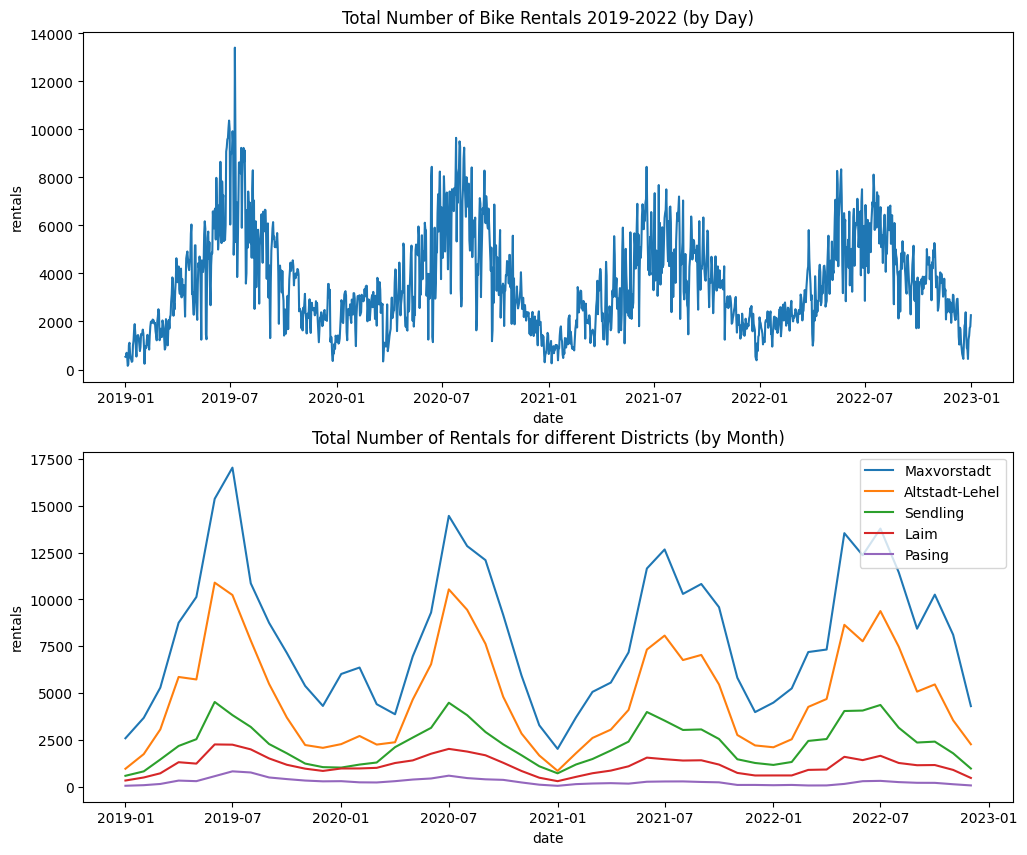

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
sns.lineplot(x=y_by_day.index, y='total_rentals', data=y_by_day, ax=ax[0])
ax[0].set_title('Total Number of Bike Rentals 2019-2022 (by Day)')
ax[0].set_ylabel('rentals')
sns.lineplot(x='year_month', y='Maxvorstadt', data=y_by_month, ax=ax[1], label='Maxvorstadt')
sns.lineplot(x='year_month', y='Altstadt-Lehel', data=y_by_month, ax=ax[1], label='Altstadt-Lehel')
sns.lineplot(x='year_month', y='Sendling', data=y_by_month, ax=ax[1], label='Sendling')
sns.lineplot(x='year_month', y='Laim', data=y_by_month, ax=ax[1], label='Laim')
sns.lineplot(x='year_month', y='Pasing', data=y_by_month, ax=ax[1], label='Pasing')
ax[1].legend(loc='upper right')
ax[1].set_title('Total Number of Rentals for different Districts (by Month)')
ax[1].set_xlabel('date')
ax[1].set_ylabel('rentals');

In [ ]:
y['date_hour'] = y.date_hour.dt.floor('H')

In [ ]:
y.drop(columns=['year_month', 'total_rentals', 'date']).set_index('date_hour').loc['2021-06-21 07:00:00':'2021-06-21 12:00:00']

,Neuhausen-Nymphenburg,Berg am Laim,Ramersdorf-Perlach,Obermenzing,Schwabing-West,Langwied,Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Harlaching,Ramersdorf,...,Untergiesing,Sendling,Aubing-Lochhausen-Langwied,Obersendling,Moosach,Hadern,Lochhausen,Milbertshofen-Am Hart,Pasing,Hasenbergl-Lerchenau Ost
date_hour,,,,,,,,,,,,,,,,,,,,,
2021-06-21 08:00:00,26,4,1,0,24,0,11,22,3,0,...,6,10,0,0,1,2,0,4,0,1
2021-06-21 09:00:00,10,0,6,0,8,0,10,12,0,0,...,1,6,0,0,1,0,0,8,1,0
2021-06-21 10:00:00,11,1,3,0,7,0,10,9,1,0,...,8,4,0,1,4,1,0,4,0,0
2021-06-21 10:00:00,11,1,3,0,9,0,16,11,0,0,...,4,8,0,0,5,0,0,1,0,0
2021-06-21 12:00:00,14,4,4,0,11,0,11,13,0,0,...,2,8,0,1,3,0,0,6,0,0


In [ ]:
type(start), type(end)

(numpy.float64, numpy.float64)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

y_rnd_week = y[(y['date']>=pd.to_datetime('2022-05-09')) & (y['date']<=pd.to_datetime('2022-05-15'))]


<ipython-input-201-c05d89d26053>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  y_rnd_week = y[(y['date']>=pd.to_datetime('2022-05-09')) & (y['date']<=pd.to_datetime('2022-05-15'))]


<ipython-input-216-881eda62a5a5>:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  y_rnd_week = y[(y['date']>=pd.to_datetime(dates[i][j][0])) & (y['date']<=pd.to_datetime(dates[i][j][1]))]
<ipython-input-216-881eda62a5a5>:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  y_rnd_week = y[(y['date']>=pd.to_datetime(dates[i][j][0])) & (y['date']<=pd.to_datetime(dates[i][j][1]))]
<ipython-input-216-881eda62a5a5>:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 

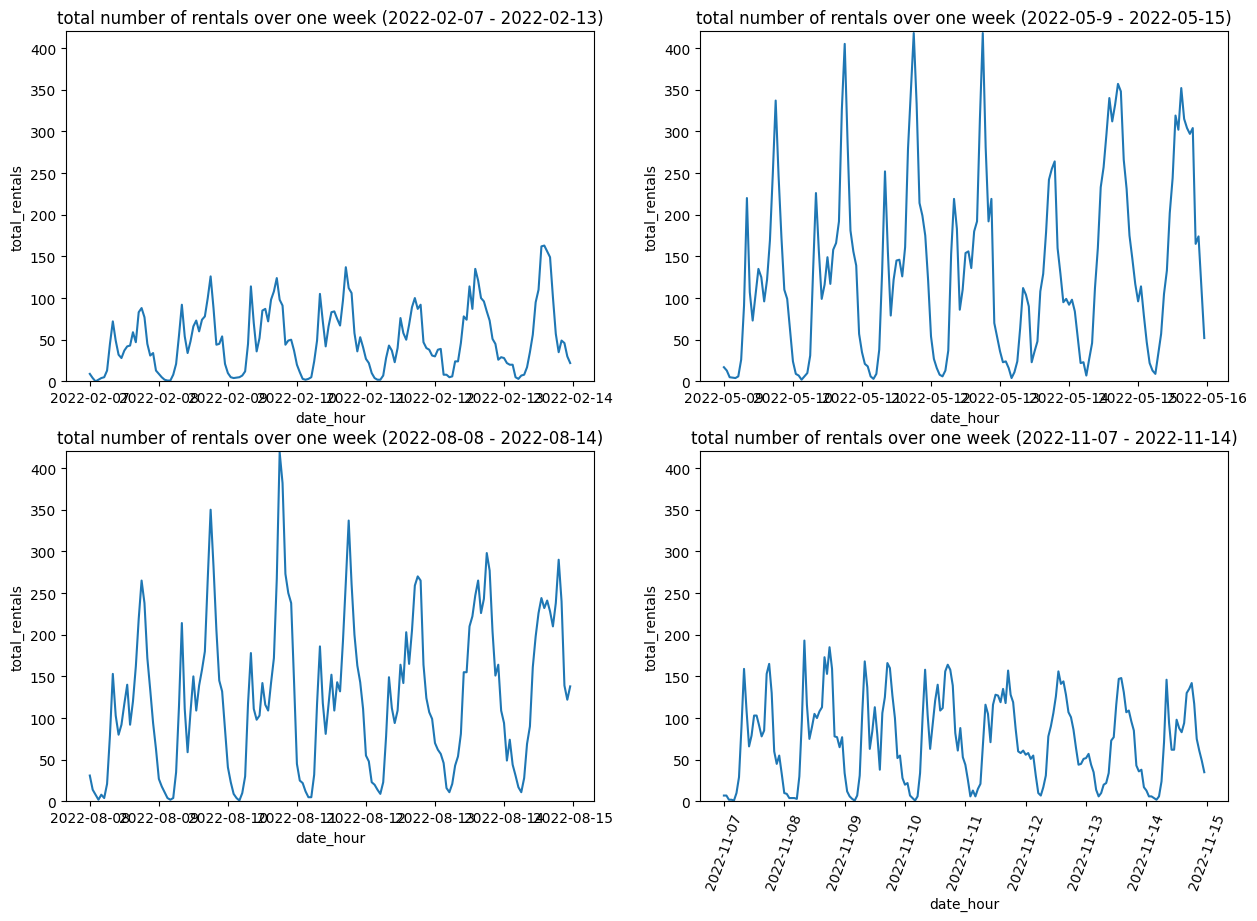

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
dates = [[('2022-02-07','2022-02-13'),('2022-05-9','2022-05-15')],[('2022-08-08','2022-08-14'),('2022-11-07','2022-11-14')]]
for i in range(2):
  for j in range(2):
    y_rnd_week = y[(y['date']>=pd.to_datetime(dates[i][j][0])) & (y['date']<=pd.to_datetime(dates[i][j][1]))]
    sns.lineplot(x='date_hour', y='total_rentals', data=y_rnd_week, ax=ax[i,j])
    ax[i,j].set_title(f'total number of rentals over one week ({dates[i][j][0]} - {dates[i][j][1]})')
    ax[i,j].set_ylim(0,420)
    plt.xticks(rotation=70)


## Correlation y <-> Weather Data


In [ ]:
y.columns

Index(['date_hour', 'Neuhausen-Nymphenburg', 'Berg am Laim',
       'Ramersdorf-Perlach', 'Obermenzing', 'Schwabing-West', 'Langwied',
       'Altstadt-Lehel', 'Ludwigsvorstadt-Isarvorstadt', 'Harlaching',
       'Ramersdorf', 'Sendling-Westpark', 'Untermenzing-Allach', 'Obergiesing',
       'Trudering-Riem', 'Au - Haidhausen', 'Schwabing-Freimann',
       'Schwanthalerhöhe', 'Pasing-Obermenzing', 'Maxvorstadt', 'Bogenhausen',
       'Thalkirchen', 'Südgiesing', 'Laim', 'Trudering',
       'Untergiesing-Harlaching', 'Feldmoching', 'Untergiesing', 'Sendling',
       'Aubing-Lochhausen-Langwied', 'Obersendling', 'Moosach', 'Hadern',
       'Lochhausen', 'Milbertshofen-Am Hart', 'Pasing',
       'Hasenbergl-Lerchenau Ost', 'total_rentals', 'date'],
      dtype='object')

In [ ]:
df_y_weather = pd.concat([data[['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation']],y[['total_rentals']]], axis=1)
df_y_weather.shape

(34718, 6)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_y_weather = pd.DataFrame(scaler.fit_transform(df_y_weather), 
                            columns=df_y_weather.columns)

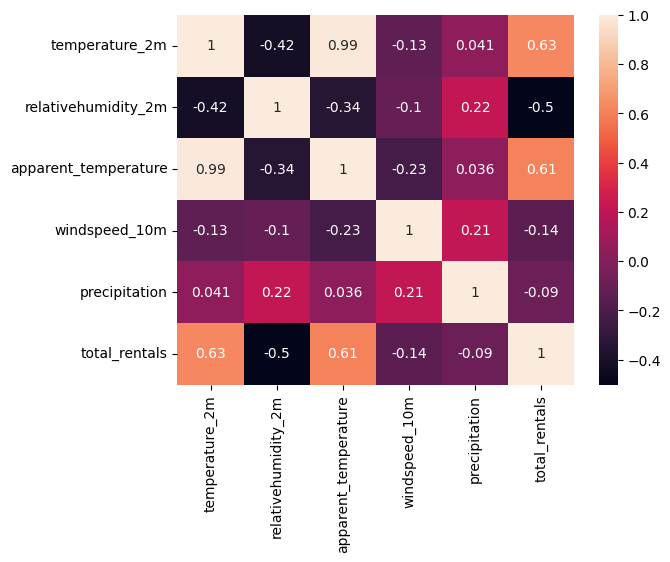

In [ ]:
sns.heatmap(df_y_weather.corr(), annot=True);

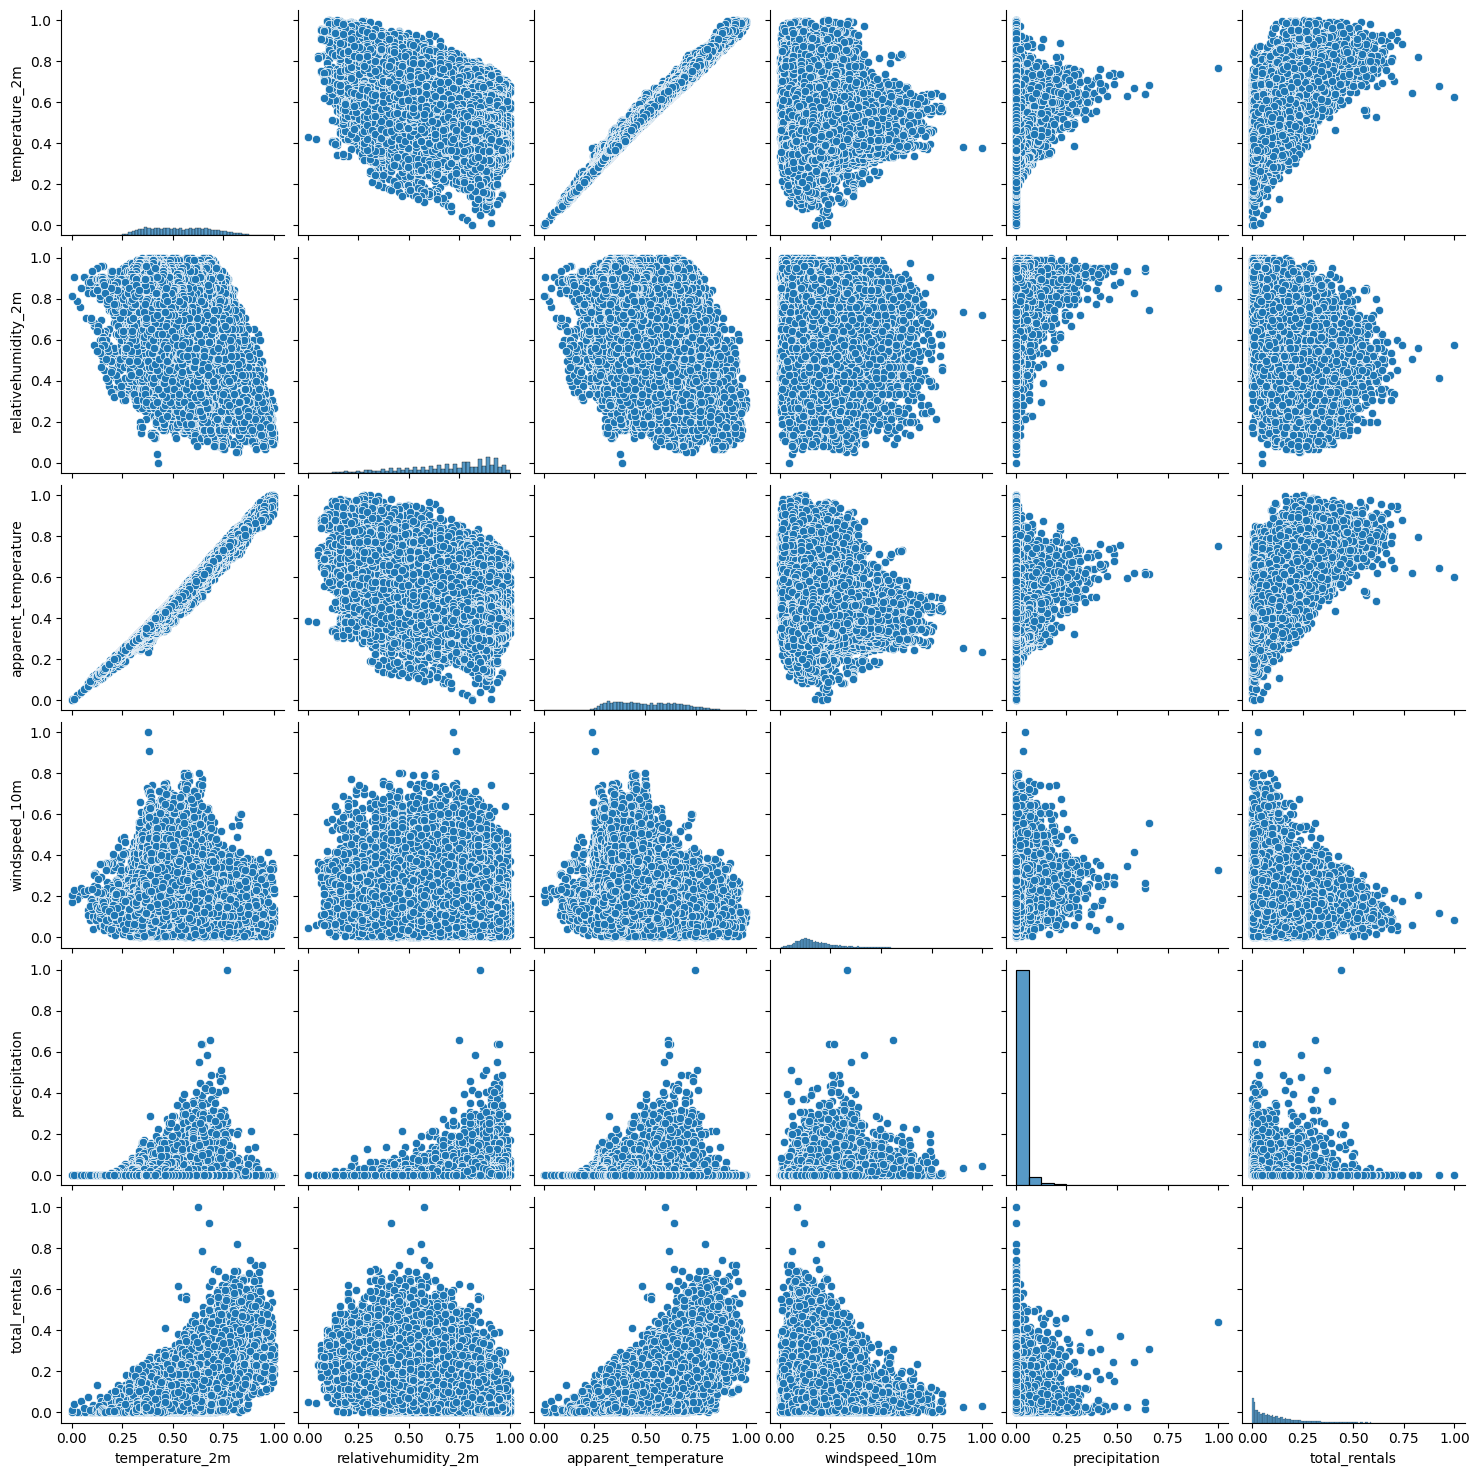

In [ ]:
sns.pairplot(df_y_weather);